<h1>Cool Maths</h1>

<h2>Local Expensive Min</h2>
<h3>Libraries</h3>

In [1]:
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import pprint
import asyncio
import scipy
import math
import bisect
from IPython import display
from IPython.display import HTML

from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.animation import HTMLWriter

from scipy import optimize as opt
from scipy.interpolate import splrep, splev, interp1d, CubicSpline

%reload_ext blackcellmagic


<h3>Functions</h3>

In [2]:
def f(x):
    return np.sin(x) + 0.05 * x ** 2
    

def slow(x):
    #await asyncio.sleep(0.01)
    y = f(x)
    return y * (1 - np.random.normal(size=np.size(y)) * 0.2)


def fit(X, Y):
    if X.size == 2:
        return interp1d(X,Y, kind = "linear")
    if X.size == 3:
        return interp1d(X, Y, kind = "quadratic")
    spl = splrep(X, Y, s = len(X)/30)
    return lambda x: splev(x, spl)


# def interpolation(X, Y, lamb = 10):
#     def toMin(X, intercept, Y, lamb):
#         #fit = CubicSpline(X, intercept)
#         leastSquare = np.sum((Y - fit(X))**2)
#         secondDerivativeSquared = lambda x: (fit.derivative(2))(x) ** 2
#         interval = np.linspace(X[0], X[-1], 10000)
#         diffX = interval[1:] - interval[:-1]
#         integral = np.sum(secondDerivativeSquared(interval[1:]) * diffX)
#         return leastSquare + lamb * integral

#     ints = opt.fmin(lambda f: toMin(X, f, Y, lamb), np.array(Y), disp=False)
#     return CubicSpline(X, ints)


async def uncertainty(fit, limits, X, x):
    async def height(fit, limits, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        y = fit(x)
        y -= y.min()
        y *= 9.9 / y.max()
        return (10 - y)**2.5

    async def sparcity(fit, limits, X, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        index = 0
        prob = np.zeros_like(x)
        for j, point in enumerate(x):
            if point == X[index]:
                continue
            else:
                while point > X[index]:
                    index += 1
                prob[j] = min(X[index] - point, point - X[index - 1])
        prob *= 100 / prob.max()
        return prob

    probY = height(approx, limits, x)
    probX = sparcity(approx, limits, X, x)
    return await (probY) * await (probX)

    


This Method = -1.6439796304286856
fminbound with same number of iterations = -1.149646760359475
fminbound with 500 iterations max = -1.427552619970902


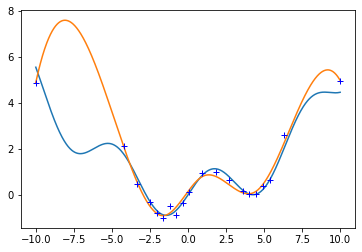

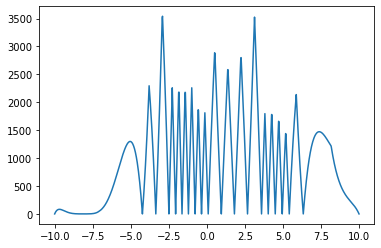

In [3]:
limits = np.array([-10, 10], dtype=float)
line = None
funIt = 20
x = np.linspace(*limits, 1000)
plt.figure(0)

plt.plot(x, f(x))

X = limits
Y = slow(limits)
xs = np.zeros([funIt-2, len(x)])
ys = np.zeros([funIt-2, len(x)])
for i in range(funIt-2):
    approx = fit(X, Y)

    error = await uncertainty(fit, limits, X, x)
    nxt = np.argmax(error)

    index = bisect.bisect(X, x[nxt])
    X = np.insert(X, index, x[nxt])
    Y = np.insert(Y, index, slow(x[nxt]))
    
    xs[i,:] = x
    ys[i,:] = approx(x)
    
approx = fit(X, Y)
error = await uncertainty(approx, limits, X, x)
plt.figure(0)
plt.plot(x, approx(x))
plt.figure(0)
plt.plot(X, Y, "b+")
plt.figure(1)
plt.plot(x, error)

print(f"This Method = {opt.fminbound(approx, *limits, disp = 0)}")
print(f"fminbound with same number of iterations = {opt.fminbound(slow, *limits, disp = 0, maxfun = funIt)[0]}")
print(f"fminbound with 500 iterations max = {opt.fminbound(f, *limits, disp = 0)}")


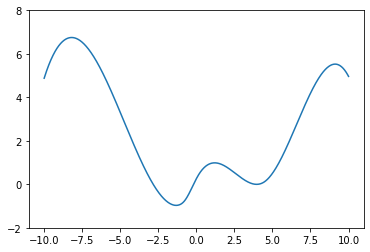

In [4]:
Figure = plt.figure()
lines_plotted = plt.plot([])
line_plotted = lines_plotted[0]
plt.xlim([-11, 11])
plt.ylim((-2, 8))
pltName = "optimiser.html"

def createGif(frame, x, y):
    line_plotted.set_data((x[frame,:], y[frame,:]))


anim_created = FuncAnimation(
    Figure, lambda i: createGif(i, xs, ys), frames=funIt-2)

writer = HTMLWriter(fps = 2)
anim_created.save(pltName, writer=writer)
HTML(pltName)
